## Tensorflow implementation of googLeNet 

This specific model is outlined in "Going deeper with convolutions", authored by Christian Szegedy, Wei Liu, among others. I will be using this model to handle a simple image recognition task, with the intention of the notebook to create a low bias model with a smaller number of parameters than a traditional convnet.

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from keras import backend as K
import matplotlib.pyplot as plt
import latex
import os
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


### Preparing data

In [2]:
# Getting images and their labels
path = "../../data/Sign-Language-Digits-Dataset/Dataset/"
imgs = []
encodings = []
for folder in os.listdir(path):
    if folder[0] != ".":
        name = folder
        for image in os.listdir(path+folder):
            if ".JPG" in image:
                aimg = cv2.imread(path+folder+"/"+image,1)
                if aimg.shape == (100,100,3):
                    imgs.append(aimg)
                    encodings.append(name)

In [3]:
# Vectorizing numbered labels
final_encodings = []
for encoding in encodings:
    enc_num = int(encoding)
    enc_swp = np.zeros((10,))
    enc_swp[enc_num] = 1
    final_encodings.append(enc_swp)

In [4]:
X = np.array(imgs)
y = np.array(final_encodings)
print(X.shape)
print(y.shape)

(2059, 100, 100, 3)
(2059, 10)


In [5]:
np.save("../../data/signs_data/X.npy",X)
np.save("../../data/signs_data/y.npy",y)

In [6]:
# Checkpoint
X = np.load("../../data/signs_data/X.npy")
y = np.load("../../data/signs_data/y.npy")
print(X.shape)
print(y.shape)

(2059, 100, 100, 3)
(2059, 10)


In [7]:
# This particular model uses encodings of shape (224,224,3) so reshaping input 
resized_imgs = []
for i in range(X.shape[0]):
    r_img = cv2.resize(X[i], (224, 224))
    resized_imgs.append(r_img)
print(len(resized_imgs))

2059


In [8]:
images = np.array(resized_imgs)
encodings = y
print(images.shape)
print(encodings.shape)

(2059, 224, 224, 3)
(2059, 10)


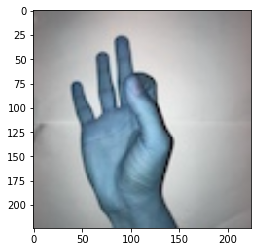

encoding: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [9]:
plt.imshow(images[0])
plt.show()
print("encoding:",encodings[0])

### Tensorflow placeholders

In [10]:
# Placeholder values for input X,y data
def get_placeholders(x_h,x_w,x_c,y_c):
    """
    x_h: Height for x input 
    x_w: Width for x input
    x_c: Channels for x input
    y_c: Channels for y input
    """
    X = tf.placeholder(tf.float32, name="X", shape=(None,x_h,x_w,x_c))
    y = tf.placeholder(tf.float32, name="y", shape=(None,y_c))
    return X,y

In [11]:
# Testing placeholders
tf.reset_default_graph()
with tf.Session() as sess:
    X,y = get_placeholders(224,224,3,10)
    print("X shape:",X.shape)
    print("y shape:",y.shape)

X shape: (?, 224, 224, 3)
y shape: (?, 10)


### Tensorflow Forward Propagation

Within the inception block, the filters input describes the number of filters used for both the bottleneck conv layers and the nxn conv layers and is as follows: [1x1 conv [f1], 1x1 conv(bottleneck) [f2], 3x3 conv [f3], 1x1 conv(bottleneck) [f4], 5x5 conv [f5], 1x1 conv(bottleneck for maxpool) [f6]]

In [12]:
# Corresponds with two softmax outputs before the final softmax output at the end of the model
# Input of shape 14x14xchannels
def early_softmax(the_input,stage,f):
    """
    stage: a,b depending on which softmax stage
    """
    Avg = tf.layers.average_pooling2d(the_input,pool_size=[5,5],strides=3,padding="valid",name="AP"+stage) # 4x4xC
    Conv = tf.layers.conv2d(Avg,filters=f,kernel_size=[1,1],strides=(1,1),padding="same",name="Conv"+stage,kernel_initializer=tf.contrib.layers.xavier_initializer(seed=0))
    Conv_A = tf.nn.relu(Conv,name="Conv_A"+stage)
    Flat_A = tf.layers.flatten(Conv_A,name="Flatten_"+stage)
    Dense_1 = tf.layers.dense(Flat_A,1024,activation=tf.nn.relu,name="Fc1_"+stage)
    Drop_1 = tf.layers.dropout(Dense_1,rate=0.4,name="Drop1_"+stage)
    Dense_2 = tf.layers.dense(Drop_1,f,activation=tf.nn.relu,name="Fc2_"+stage)
    Drop_2 = tf.layers.dropout(Dense_2,rate=0.4,name="Drop2_"+stage)
    linear = tf.layers.dense(Drop_2,10,activation=None,name="linear_"+stage)
    return linear

In [13]:
# Corresponds with a inception block, including depth concatenation
# s: number of the inception stage, blocks within a stage are labled alphabetically
def inception_step(the_input,filters,s):
    f1,f2,f3,f4,f5,f6 = filters
    s = str(s)
    # Block 1:
    Z1 = tf.layers.conv2d(the_input,filters=f1,kernel_size=[1,1],strides=(1,1),padding="same",name="Z1_"+s,kernel_initializer=tf.contrib.layers.xavier_initializer(seed=0))
    A1 = tf.nn.relu(Z1,name="A1_"+s)
    # Block 2:
    # 3x3 bottleneck
    Z2a = tf.layers.conv2d(the_input,filters=f2,kernel_size=[1,1],strides=(1,1),padding="same",name="Z2a_"+s,kernel_initializer=tf.contrib.layers.xavier_initializer(seed=0))
    A2a = tf.nn.relu(Z2a,name="A2a_"+s)
    # 3x3 conv
    Z2b = tf.layers.conv2d(A2a,filters=f3,kernel_size=[3,3],strides=(1,1),padding="same",name="Z2b_"+s,kernel_initializer=tf.contrib.layers.xavier_initializer(seed=0))
    A2b = tf.nn.relu(Z2b,name="A2b_"+s)
    # Block 3:
    # 5x5 bottleneck
    Z3a = tf.layers.conv2d(the_input,filters=f4,kernel_size=[1,1],strides=(1,1),padding="same",name="Z3a_"+s,kernel_initializer=tf.contrib.layers.xavier_initializer(seed=0))
    A3a = tf.nn.relu(Z3a,name="A3a_"+s)
    # 5x5 conv
    Z3b = tf.layers.conv2d(A3a,filters=f5,kernel_size=[5,5],strides=(1,1),padding="same",name="Z3b_"+s,kernel_initializer=tf.contrib.layers.xavier_initializer(seed=0))
    A3b = tf.nn.relu(Z3b,name="A3b_"+s)
    # Block 4
    P4 = tf.layers.max_pooling2d(the_input,pool_size=[3,3],strides=1,padding="same",name="P4_"+s)
    Z4 = tf.layers.conv2d(P4,filters=f6,kernel_size=[1,1],strides=(1,1),padding="same",name="Z4_"+s,kernel_initializer=tf.contrib.layers.xavier_initializer(seed=0))
    A4 = tf.nn.relu(Z4,name="A4_"+s)
    # Concat all 4 blocks
    Dc = tf.concat([A1,A2b,A3b,A4],axis=-1,name="concat_"+s)
    return Dc

In [14]:
# There will be three softmax outputs returned
def forward_pass(X):
    input_layer = tf.reshape(X,[-1,224,224,3]) # Input shape of images
    # Pre-inception
    Z1 = tf.layers.conv2d(input_layer,filters=64,kernel_size=[7,7],strides=(2,2),padding="same",name="Z1",kernel_initializer=tf.contrib.layers.xavier_initializer(seed=0))
    A1 = tf.nn.relu(Z1,name="A1") # 112x112
    P1 = tf.layers.max_pooling2d(A1,pool_size=[3,3],strides=2,padding="same",name="P1") # 56x56
    LRN1 = tf.nn.local_response_normalization(P1,name="LRN1")
    Z2 = tf.layers.conv2d(LRN1,filters=64,kernel_size=[1,1],strides=(1,1),padding="valid",name="Z2",kernel_initializer=tf.contrib.layers.xavier_initializer(seed=0))
    A2 = tf.nn.relu(Z2,name="A2")
    Z3 = tf.layers.conv2d(A2,filters=192,kernel_size=[3,3],strides=(1,1),padding="same",name="Z3",kernel_initializer=tf.contrib.layers.xavier_initializer(seed=0))
    A3 = tf.nn.relu(Z3,name="A3")
    LRN3 = tf.nn.local_response_normalization(A3,name="LRN3")
    P3 = tf.layers.max_pooling2d(LRN3,pool_size=[3,3],strides=2,padding="same",name="P3") # 28x28x192
    # Inception starts
    Inc1 = inception_step(P3,[64,96,128,16,32,32],1) # 28x28x256
    Inc2 = inception_step(Inc1,[128,128,192,32,96,64],2) #28x28x480
    P4 = tf.layers.max_pooling2d(Inc2,pool_size=[3,3],strides=2,padding="same",name="P4") # 14x14x480
    Inc3 = inception_step(P4,[192,96,208,16,48,64],3) #14x14x512
    # First early softmax
    ESM1 = early_softmax(Inc3,"a",512)
    Inc4 = inception_step(Inc3,[160,112,224,24,64,64],4) # 14x14x512
    Inc5 = inception_step(Inc4,[128,128,256,24,64,64],5) # 14x14x512
    Inc6 = inception_step(Inc5,[112,144,288,32,64,64],6) # 14x14x528
    # Second early softmax
    ESM2 = early_softmax(Inc6,"b",528)
    Inc7 = inception_step(Inc6,[256,160,320,32,128,128],7) # 14x14x832
    P5 = tf.layers.max_pooling2d(Inc7,pool_size=[3,3],strides=2,padding="same",name="P5") # 7x7x832
    Inc8 = inception_step(P5,[256,160,320,32,128,128],8) # 7x7x832
    Inc9 = inception_step(Inc8,[384,192,384,48,128,128],9) # 7x7x1024
    # Last softmax output
    AP = tf.layers.average_pooling2d(Inc9,pool_size=[7,7],strides=1,padding="valid",name="APc") # 1x1x1024
    Flat = tf.layers.flatten(AP,name="Flatten_c")
    Dense = tf.layers.dense(Flat,500,activation=tf.nn.relu,name="Fc1_c")
    Drop = tf.layers.dropout(Dense,rate=0.4,name="Drop1_c")
    ESM3 = tf.layers.dense(Drop,10,activation=None,name="linear_c")
    
    return [ESM1,ESM2,ESM3]

In [15]:
# Testing forward prop step
test_img = images[0]
test_img.shape = (1,224,224,3)
test_enc = encodings[0]
test_enc.shape = (1,10)
tf.reset_default_graph()
with tf.Session() as sess:
    X,y = get_placeholders(224,224,3,10)
    Z = forward_pass(X)
    init = tf.global_variables_initializer()
    sess.run(init)
    aZ = sess.run(Z,feed_dict={X:test_img,y:test_enc})
    print(aZ[2].shape)

(1, 10)


### Tensorflow Cost Function

The cost function for this model is simple in that it is a simple softmax cross entropy loss. The only complexity related to this is the fact that there are three softmax outputs from the original model corresponding to predictions at different depths within the model. I plan on putting more weight on the softmax outputs from the deeper portions of the model rather than having there be an equal weighting: 0.4 for the last softmax output and 0.3 for the first two softmax outputs.

In [16]:
# Takes in a list of costs and the correct encoding and returns a weighted cost of the softmax predictions
# Out3 corresponds with the last softmax prediction
def cost_function(outputs,y):
    out1,out2,out3 = outputs
    cost_a = 0.3 * tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=out1,labels=y))
    cost_b = 0.3 * tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=out2,labels=y))
    cost_c = 0.4 * tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=out3,labels=y))
    full_cost = cost_a + cost_b + cost_c
    return full_cost

In [17]:
# Testing cost function
test_img = images[0]
test_img.shape = (1,224,224,3)
test_enc = encodings[0]
test_enc.shape = (1,10)
tf.reset_default_graph()
with tf.Session() as sess:
    X,y = get_placeholders(224,224,3,10)
    Z = forward_pass(X)
    cost = cost_function(Z,y)
    init = tf.global_variables_initializer()
    sess.run(init)
    aCost = sess.run(cost,feed_dict={X:test_img,y:test_enc})
    print("Cost:",aCost)

Cost: 2.3147223


### Tensorflow Model

In [18]:
# Using stochastic gradient descent
def model(images,encodings,lr=0.0001,num_epochs=5,print_cost=True):
    tf.reset_default_graph() # resetting graph
    tf.set_random_seed(1)
    seed = 0
    costs=[]
    x_h = images[0].shape[0]
    x_w = images[0].shape[1]
    x_c = images[0].shape[2]
    
    X,y = get_placeholders(x_h,x_w,x_c,10) # 10 classes
    Z = forward_pass(X)
    cost = cost_function(Z,y)
    optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)
    
    init = tf.global_variables_initializer()
    saver = tf.train.Saver() # to save/load model
    with tf.Session() as sess:
        # Loading saved model
        # saver = tf.train.import_meta_graph("../../data/googlenet/inception_model.ckpt.meta")
        # saver.restore(sess, "../../data/googlenet/inception_model.ckpt")
        sess.run(init) # DON'T RUN INIT IF LOADING MODEL
        
        for epoch in range(num_epochs):
            running_cost = 0
            # shuffle data for each epoch
            seed += 1
            images = shuffle(images,random_state=seed)
            encodings = shuffle(encodings,random_state=seed)
            
            for i in range(images.shape[0]):
                a_img = images[i]
                a_enc = encodings[i]
                a_img.shape = (1,224,224,3)
                a_enc.shape = (1,10)
                _,temp_cost = sess.run([optimizer,cost], feed_dict={X:a_img,y:a_enc})
                running_cost += temp_cost
                # print("running cost: "+str(running_cost) + " ,temp_cost: " + str(temp_cost)+".")
                
            costs.append(running_cost)
            if print_cost and epoch % 1 == 0:
                print("Cost at epoch {}: {}".format(epoch+1,running_cost))
                
        loc = saver.save(sess, "../../data/googlenet/inception_model.ckpt")
        return costs

In [ ]:
acosts1 = model(images,encodings,lr=0.00001,num_epochs=15,print_cost=True)

In [ ]:
X_iter = [i for i in range(15)]
all_costs = acosts1
plt.plot(x_iter,all_costs)
plt.title("Cost vs epoch")
plt.xlabel("epoch #")
plt.ylabel("cost")
plt.show()

In [27]:
acosts1 = model(images,encodings,lr=0.00001,num_epochs=8,print_cost=True)

Cost at epoch 1: 4228.0040545761585
Cost at epoch 2: 2007.4463422904955
Cost at epoch 3: 1242.6089914250133
Cost at epoch 4: 834.4975922296275
Cost at epoch 5: 614.461458436151
Cost at epoch 6: 468.2891068336725
Cost at epoch 7: 380.3431925270951
Cost at epoch 8: 329.67680578217545


In [31]:
acosts2 = model(images,encodings,lr=0.000001,num_epochs=8,print_cost=True)

INFO:tensorflow:Restoring parameters from ../../data/googlenet/inception_model.ckpt
Cost at epoch 1: 4737.832586288452
Cost at epoch 2: 4729.91846871376
Cost at epoch 3: 4700.812566041946
Cost at epoch 4: 4566.428528666496
Cost at epoch 5: 4152.427567362785
Cost at epoch 6: 3676.3979907035828
Cost at epoch 7: 3277.0295738875866
Cost at epoch 8: 2953.4947279393673


In [32]:
acosts3 = model(images,encodings,lr=0.0000001,num_epochs=8,print_cost=True)

INFO:tensorflow:Restoring parameters from ../../data/googlenet/inception_model.ckpt
Cost at epoch 1: 2770.913605131209
Cost at epoch 2: 2742.001461520791
Cost at epoch 3: 2717.341639958322
Cost at epoch 4: 2694.030679680407
Cost at epoch 5: 2670.079291962087
Cost at epoch 6: 2646.9252618551254
Cost at epoch 7: 2625.2605364471674
Cost at epoch 8: 2604.8839012756944
